<a href="https://colab.research.google.com/github/coddmajes/deep-learning/blob/master/uISTA_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**uISTA by tensorflow**

In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
from scipy import linalg

from time import time
import matplotlib.pyplot as plt

import logging
logging.getLogger('temsorflow').disabled = True


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
if tf.test.is_gpu_available():
  print("The following GPU devices are avaliable: %s" % tf.test.gpu_device_name())
  !/opt/bin/nvidia-smi
  !/usr/bin/nvidia-smi -L

#device = tf.device(tf.test.gpu_device_name())


The following GPU devices are avaliable: /device:GPU:0
Tue Feb 18 05:34:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    34W / 250W |    265MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                     

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('没有发现GPU device')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


**tensorflow with GPU**

In [0]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.ConfigProto()
config.allow_soft_placement=True
#config.gpu_options.per_process_gpu_memory_fraction = 0.4
config.gpu_options.allow_growth=True
#sess = tf.Session(config = config)

**data preparation**  

In [0]:
n_samples = 400

# generate sythetic data for demo
rng = np.random.RandomState(int(time()))
#m, n = 512, 2048
m, n = 256,1024
#m, n = 2000, 4000

# use a random matrix as a basis (design matrix)
A = rng.randn(m, n) / np.sqrt(m)

# generate k-sparse Gaussian signal vectors
k = 50
stdx = 1.
snr = 10.

# e.g range(0, 30, 5) => [0, 5, 10, 15, 20, 25]
support_range = np.arange(0, max(int(n/4), k))
# print(support_range)

input_data = np.zeros((n_samples, m))
output_data = np.zeros((n_samples, n))
for i in range(n_samples) :

    x_true = np.zeros(n,dtype=np.float32)
    # e.g np.random.choice(5, 3) => array([0, 3, 4])
    T = rng.choice(len(support_range), k, replace=False)
    
    # 为什么support_range 是 256以内？？  实验结果shows
    x_true[support_range[T]] = rng.randn(k) * stdx
    #print()

    # make the query vector
    b = A.dot(x_true)

    # add noise
    normb = linalg.norm(b)
    noise = rng.randn(m)
    noise = noise / linalg.norm(noise) * normb / snr
    b = b + noise
    
    input_data[i, :] = b
    output_data[i, :] = x_true


In [6]:
n_train = min(300, n_samples)
from sklearn.model_selection import train_test_split
input_train, input_test, output_train, output_test = train_test_split(input_data, output_data, test_size=n_train)

print(input_train.shape)
print(output_train.shape)
#np_input_train = input_train.copy()
#np_output_train = output_train.copy()

(100, 256)
(100, 1024)


**ISTA with numpy**

In [0]:
# soft thresholding function
def soft(z, th):
    return np.sign(z) * np.maximum(np.abs(z) - th, 0)
    # np.sign(z) if z>0 return 1 else return -1

from scipy import linalg
# Iterative soft thresholding (IST)
def ISTA(A, b, tol=1e-5, maxiter=300, l=1., L=None):
    m, n = A.shape
    x = np.zeros(n)
    r = b.copy()
    if L is None:    # roughly estimate the Lipschitz constant
        L = 2*linalg.norm(A.dot(A.T.dot(b))) / linalg.norm(b)
    count = 0
    cost_history = []
    normr = linalg.norm(r)
    while count < maxiter and normr > tol:
        count += 1
        x = soft(x + A.T.dot(r) / L, l/L)
        r = b - A.dot(x)
        normr = linalg.norm(r)
        #print(np.sum(np.abs(x)))
        cost_history.append( normr*normr + l*np.sum(np.abs(x)) )

    return x, cost_history

done 100 steps in 28.11ms by numpy
2.864935841732198


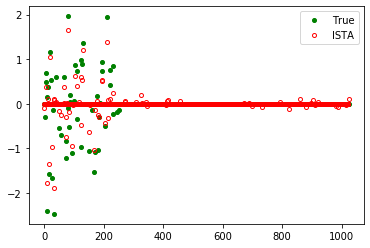

In [8]:
# pick up a test sample, and show the estimate
b = input_test[0,:]
x_true = output_test[0,:]

# l 
l = 1.*(stdx*stdx / k * m) / np.sqrt(snr) / normb
L = 2*linalg.norm(A.dot(A.T.dot(b))) / linalg.norm(b)
maxit = 100

t0 = time()
x_est = ISTA(A, b, maxiter=maxit, l=l, L=L)[0]
print('done %d steps in %.2fms by numpy' % (maxit, (time() - t0)*1000))

print(np.linalg.norm(x_true-x_est))
import matplotlib.pyplot as plt
plt.plot(np.arange(n), x_true, 'g.', markersize=8, mec='green', label='True')
plt.plot(np.arange(n), x_est, 'ro', mfc = 'None', markersize=4, mec='red', mew=1, label='ISTA')
plt.legend(loc='upper right', shadow=False)
plt.show()

**uISTA_tf**

In [9]:
# define parameters
from math import sqrt

NUM_EPOCHES = 100
BATCH_SIZE = 10
LEARNING_RATE = 0.00003 * sqrt(BATCH_SIZE)

N_LAYERS_UNROLL = 20

tf_l_ini = tf.ones((1,n)) * l
#print(tf_l_ini)

tf_b = tf.placeholder(tf.float32,shape=( None, m))

#print(tf_b)
#print(tf_x)

tf_A = tf.Variable(tf.convert_to_tensor(A, tf.float32), name='tf_A')
tf_l = tf.Variable(tf.convert_to_tensor(tf_l_ini, tf.float32), name='tf_l') 

'''
sess=tf.InteractiveSession()#使用InteractiveSession函数
tf_A.initializer.run()#使用初始化器 initializer op 的 run() 方法初始化 'biases' 
print(sess.run(tf_A))
'''

"\nsess=tf.InteractiveSession()#使用InteractiveSession函数\ntf_A.initializer.run()#使用初始化器 initializer op 的 run() 方法初始化 'biases' \nprint(sess.run(tf_A))\n"

In [0]:
def tf_soft(tf_z, tf_th):
  with tf.device('/device:GPU:0'):
    return tf.multiply(tf.sign(tf_z),tf.maximum(tf.abs(tf_z) - tf_th, 0))

In [0]:
# uISTA model
def uISTA_model():
  with tf.device('/device:GPU:0'): 
    tf_theta = tf.multiply(tf_l,1/L)
    x = tf_soft(tf.matmul(tf.multiply(1./L, tf_b), tf_A), tf_theta)
    #print(x.shape)
    for i in range(1,N_LAYERS_UNROLL):
      #x + 1/L*A.t(b-Ax)
      x = tf_soft(x + tf.multiply(tf.matmul((tf_b - tf.matmul(x, tf.transpose(tf_A))), tf_A),1./L), tf_theta) 
    return x


done 20 layers in 7658.83ms
4.493203463969797
2.864935841732198


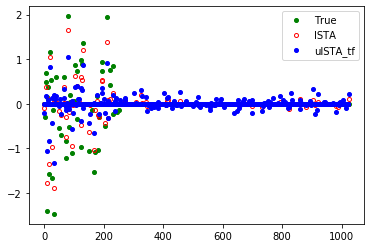

In [12]:
u_x = uISTA_model()

b = b.reshape(1,m)
tf_t0 = time()
with tf.Session(config = config) as sess:
  sess.run(tf.global_variables_initializer())
  tf_x = sess.run(u_x, feed_dict={tf_b:b})
print('done %d layers in %.2fms' % (N_LAYERS_UNROLL, (time() - tf_t0)*1000))

print(np.linalg.norm(tf_x-x_true))
print(np.linalg.norm(x_est-x_true))

plt.plot(np.arange(n), x_true, 'g.', markersize=8, mec='green', label='True')
plt.plot(np.arange(n), x_est, 'ro', mfc = 'None', markersize=4, mec='red', mew=1, label='ISTA')
plt.plot(np.arange(n), tf_x.T, 'b.', markersize=8, mec='blue', label='uISTA_tf')
plt.legend(loc='upper right', shadow=False)
plt.show()


**Optimize the model**

In [0]:
# training data preparation

BATCH_SIZE = 10
BUFFER_SIZE = 10000
NUM_EPOCHES = 100
LEARNING_RATE = 0.000045 * sqrt(BATCH_SIZE)

tf_labelx = tf.placeholder(tf.float32,shape=( None, n))
#print(tf_A.shape)
#print(tf_l.shape)

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# define loss and optimizer
with tf.device('/device:GPU:0'):
  tf_loss = tf.losses.mean_squared_error(tf_labelx, u_x)
  tf_opt = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(tf_loss)


In [26]:
t0 = time()
with tf.Session(config = config) as sess:      
  sess.run(tf.global_variables_initializer())
  running_loss = 0.               
  for epoch in range(NUM_EPOCHES): 
    #tf_x = sess.run(u_x, feed_dict={tf_b:b})
    loss = sess.run(tf_loss, feed_dict={tf_labelx: output_train[epoch].reshape(1,n), tf_b: input_train[epoch].reshape(1,m)})
    #running_loss += loss
    sess.run(tf_opt, feed_dict={tf_labelx: output_train[epoch].reshape(1,n), tf_b: input_train[epoch].reshape(1,m)})
    var_l = sess.run(tf_l)
    if (epoch+1) % BATCH_SIZE == 0:
      print ('Epoch [{:3d}/{}]: loss = {:.4f},  '.format(epoch+1, NUM_EPOCHES, loss), end=' ')
      print('l in [{:.4f}, {:.4f}]'.format(var_l.min(), var_l.max()))
      print('\n')
  #save the variables
  save_path = saver.save(sess, "/tmp/model.ckpt")
print('done in %.2fs' % (time() - t0))

Epoch [ 10/100]: loss = 0.0296,   l in [0.2916, 0.2937]


Epoch [ 20/100]: loss = 0.0232,   l in [0.2911, 0.2944]


Epoch [ 30/100]: loss = 0.0225,   l in [0.2906, 0.2950]


Epoch [ 40/100]: loss = 0.0308,   l in [0.2901, 0.2961]


Epoch [ 50/100]: loss = 0.0195,   l in [0.2895, 0.2969]


Epoch [ 60/100]: loss = 0.0231,   l in [0.2888, 0.2976]


Epoch [ 70/100]: loss = 0.0211,   l in [0.2883, 0.2981]


Epoch [ 80/100]: loss = 0.0219,   l in [0.2876, 0.2987]


Epoch [ 90/100]: loss = 0.0152,   l in [0.2872, 0.2994]


Epoch [100/100]: loss = 0.0246,   l in [0.2866, 0.3000]


done in 2.26s


INFO:tensorflow:Restoring parameters from /tmp/model.ckpt
done 20 layers in 442.71ms
4.412496555251069
2.864935841732198


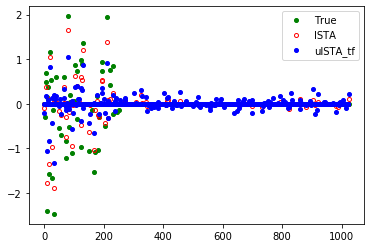

In [27]:
opt_x = uISTA_model()
b = b.reshape(1,m)
tf_t0 = time()
with tf.Session(config = config) as sess:
  saver.restore(sess, "/tmp/model.ckpt")
  #sess.run(tf.global_variables_initializer())
  op_tf_x = sess.run(opt_x, feed_dict={tf_b:b})
print('done %d layers in %.2fms' % (N_LAYERS_UNROLL, (time() - tf_t0)*1000))

print(np.linalg.norm(op_tf_x-x_true))
print(np.linalg.norm(x_est-x_true))
plt.plot(np.arange(n), x_true, 'g.', markersize=8, mec='green', label='True')
plt.plot(np.arange(n), x_est, 'ro', mfc = 'None', markersize=4, mec='red', mew=1, label='ISTA')
plt.plot(np.arange(n), tf_x.T, 'b.', markersize=8, mec='blue', label='uISTA_tf')
plt.legend(loc='upper right', shadow=False)
plt.show()

In [0]:
#plt.plot(np.arange(n), model.l.detach().cpu().numpy().ravel(), 'k.', markersize=8, mec='k', label='lambda')
#plt.legend(loc='upper right', shadow=False)

**SALSA untrolled**  

In [0]:
import torch
from torch.utils.data import DataLoader,TensorDataset
print(torch.__version__)
device = torch.device('cpu')

In [0]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    print(torch.cuda.memory_allocated())
    print(torch.cuda.memory_cached())
    torch.cuda.empty_cache()

In [0]:
class uSALSA(torch.nn.Module):
  def __init__(self, num_unroll, A, l=1., scale=1., prox=None):
    super(uSALSA, self).__init__()
    self.num_unroll = num_unroll
    self.A = torch.nn.Parameter(torch.FloatTensor(A), requires_grad=True)
    self.l = torch.nn.Parameter(torch.FloatTensor([l]), requires_grad=True)
    self.scale = scale
    if prox is None:
      self.prox = lambda z, th: z.sign() * (z.abs_() - th).max(torch.tensor(0, device=device).float())
    else:
      self.prox = prox
            
  def forward(self, b):
    theta = torch.mul(self.l, self.scale)
    print(theta.shape)
    #print('ok')
    x = torch.matmul(self.A.t(), b.t())
    print(x.shape)
    #print('ok')
    z = self.prox(x, theta.t())
    print(z.shape)
    u = x - z
    print(u.shape)
    print((torch.inverse(torch.matmul(self.A.t(), self.A) + 1./self.scale)).shape)
    print((torch.matmul(self.A.t(), b.t()) + torch.mul(1./self.scale, z)).shape)
    for i in range(self.num_unroll):
      # x = prox(x+A.T.dot(b-A.dot(x))*scale, theta)
      x = torch.matmul(torch.inverse(torch.matmul(self.A.t(), self.A) + 1./self.scale), (torch.matmul(self.A.t(), b.t()) + torch.mul(1./self.scale, z)))
      print(x.shape)
      z = self.prox(x + u, theta) - u
      u = x - z
      #x = self.prox(x + (b - x.matmul(self.A.t())).mul_(self.scale).matmul(self.A), theta)
    return x

In [0]:
n_layers_unroll  = 20

#l_ini = l
l_ini = np.ones(n) * l

model = uSALSA(n_layers_unroll, A, l=l_ini, scale=1./L).to(device=device)

print('Is model parameters on GPU? :', next(model.parameters()).is_cuda)
for param in model.parameters():
    print(type(param.data), param.size(), ', is_cuda:', param.is_cuda)

In [0]:
b_torch = torch.from_numpy(b).float().to(device)
t0 = time()
with torch.no_grad():
    model_out = model(b_torch)
print('done fwd. prop. of %d layers in %.2fms' % (model.num_unroll, (time() - t0)*1000))

'''
x_usalsa = model_out.detach().cpu().numpy().ravel()
print(np.linalg.norm(x_usalsa-x_true))
print(np.linalg.norm(x_est-x_true))
plt.plot(np.arange(n), x_true, 'g.', markersize=8, mec='green', label='True')
plt.plot(np.arange(n), x_est, 'ro', mfc = 'None', markersize=4, mec='red', mew=1, label='ISTA')
plt.plot(np.arange(n), x_usalsa, 'b.', markersize=8, mec='green', label='uSALSA')
plt.legend(loc='upper right', shadow=False)
plt.show()
'''